In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

np.random.seed(42)
torch.manual_seed(42)

In [2]:
!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Sun Jun  5 06:48:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Prepare data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!python bboxes_extractor.py --save-dir data/reference_images_part1_bboxes --dir-from /content/drive/MyDrive/data/reference_images_part1 --data-json /content/drive/MyDrive/data/reference_images_part1.json

In [7]:
!python bboxes_extractor.py --save-dir data/images_part1_valid_bboxes --dir-from /content/drive/MyDrive/data/images_part1_valid --data-json /content/drive/MyDrive/data/images_part1_valid.json

# Dataset

In [60]:
from typing import Optional, Callable, Tuple, Any
import numpy as np
from PIL import Image
import os
from sklearn.preprocessing import LabelEncoder 


class MagicDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        img_dir: str,
        labels_file: Optional[str] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        encode_labels: bool = True
    ) -> None:

        self.img_dir = img_dir
        self.labels_file = labels_file
        self.data = pd.read_csv(labels_file)
        self.img_names = self.data.loc[:, "filename"]
        self.img_labels = self.data.loc[:, "category_id"]
        self.class_names = self.img_labels.unique()

        self.encode_labels = encode_labels
        if self.encode_labels:
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(self.img_labels)

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.img_names)

    def __getitem__(self, index: int):
        img_path = os.path.join(self.img_dir, self.img_names[index])
        image = Image.open(img_path).convert('RGB')

        label = self.img_labels[index]
        if self.encode_labels:
            label = self.label_encoder.transform([label])[0]

        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [9]:
IMG_DIR = './data/reference_images_part1_bboxes/images'
LABELS_FILE = './data/reference_images_part1_bboxes/bboxes_data.csv'
IMG_DIR_VAL = './data/images_part1_valid_bboxes/images'
LABELS_FILE_VAL = './data/images_part1_valid_bboxes/bboxes_data.csv'

In [48]:
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

aug_transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(),
    transforms.RandomRotation(degrees=180),                                      
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [61]:
aug_train_data = MagicDataset(img_dir=IMG_DIR, labels_file=LABELS_FILE, encode_labels=True, transform=aug_transformations)
train_data = MagicDataset(img_dir=IMG_DIR, labels_file=LABELS_FILE, encode_labels=False, transform=transformations)
val_data = MagicDataset(img_dir=IMG_DIR_VAL, labels_file=LABELS_FILE_VAL, encode_labels=False, transform=transformations)

In [62]:
BATCH_SIZE = 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
aug_train_loader = torch.utils.data.DataLoader(aug_train_data, batch_size=BATCH_SIZE, shuffle=True)

In [51]:
def imshow(img, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean # unnormalize 
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

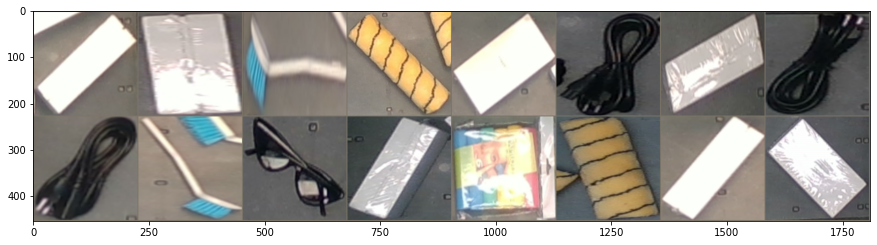

In [64]:
images, labels = next(iter(train_loader))

plt.rcParams['figure.figsize'] = 15, 10
imshow(torchvision.utils.make_grid(images[:16]))

# Model 

In [183]:
EMBEDDING_SIZE = 256

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.avgpool = nn.AdaptiveAvgPool2d(output_size=1)

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.Linear(512, 512),
    nn.Linear(512, 512),
    nn.Linear(512, EMBEDDING_SIZE),
    nn.Linear(EMBEDDING_SIZE, train_data.img_labels.nunique())
)
# model.fc2 = nn.Linear(EMBEDDING_SIZE, train_data.img_labels.nunique())


for i, child in enumerate(model.children()):
    if i < 7:
        for param in child.parameters():
            param.requires_grad = False

for param in model.named_parameters():
    if param[1].requires_grad:
        print(param[0])

model = model.to(device)

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.0.weight
fc.0.bias
fc.1.weight
fc.1.bias
fc.2.weight
fc.2.bias
fc.3.weight
fc.3.bias
fc.4.weight
fc.4.bias


In [184]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
NUM_EPOCHS = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    running_corrects = 0.0
    for inputs, labels in aug_train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        probs, preds = torch.max(F.softmax(outputs, dim=1), 1)    

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()

        loss.backward()
        optimizer.step()
    
    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects / len(train_data)

    print(f"[{epoch+1}/{NUM_EPOCHS}] Loss: {epoch_loss} Acc: {epoch_acc}")

[1/100] Loss: 2.49674916267395 Acc: 0.1111111111111111
[2/100] Loss: 1.8569884300231934 Acc: 0.3541666666666667
[3/100] Loss: 0.980682909488678 Acc: 0.8541666666666666
[4/100] Loss: 0.38898706436157227 Acc: 0.9305555555555556
[5/100] Loss: 0.17898985743522644 Acc: 0.9513888888888888
[6/100] Loss: 0.10961000621318817 Acc: 0.9513888888888888
[7/100] Loss: 0.07844228297472 Acc: 0.9513888888888888
[8/100] Loss: 0.05851208418607712 Acc: 0.9861111111111112
[9/100] Loss: 0.03571425378322601 Acc: 1.0
[10/100] Loss: 0.012087373062968254 Acc: 1.0
[11/100] Loss: 0.015260670334100723 Acc: 0.9930555555555556
[12/100] Loss: 0.0021910499781370163 Acc: 1.0
[13/100] Loss: 0.0016305510653182864 Acc: 1.0
[14/100] Loss: 0.0035514570772647858 Acc: 1.0
[15/100] Loss: 0.0004902167129330337 Acc: 1.0
[16/100] Loss: 0.005886306520551443 Acc: 0.9930555555555556
[17/100] Loss: 0.02442115731537342 Acc: 0.9930555555555556
[18/100] Loss: 0.0005611202213913202 Acc: 1.0
[19/100] Loss: 0.005657991394400597 Acc: 0.99305

In [ ]:
model.fc = model.fc[:-1]
# model = torch.nn.Sequential(*(list(model.children())[:-1]))# , torch.nn.Flatten())

In [ ]:
model.eval()

embeddings = torch.zeros((0, EMBEDDING_SIZE))
labels = torch.zeros((0))

with torch.no_grad():
    for ins, lbs in train_loader:
        ins = ins.to(device)
        lbs = lbs.to(device)
        
        labels = torch.cat([labels.cpu(), lbs.cpu()])
        embeddings = torch.cat([embeddings.cpu(), model(ins).cpu()], dim=0)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1 , metric='cosine')
knn.fit(embeddings.numpy(), labels.numpy())

In [ ]:
labels_val = torch.zeros((0))
embeddings_val = torch.zeros((0, EMBEDDING_SIZE))

with torch.no_grad():
    for ins, lbs in val_loader:
        ins = ins.to(device)
        lbs = lbs.to(device)
        
        labels_val = torch.cat([labels_val.cpu(), lbs.cpu()])
        embeddings_val = torch.cat([embeddings_val.cpu(), model(ins).cpu()], dim=0)

In [ ]:
embeddings_val.numpy().shape

In [ ]:
preds = knn.predict(embeddings_val)

In [ ]:
from sklearn.metrics import accuracy_score

print("Accuracy: ", accuracy_score(labels_val.numpy(), preds))